In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/project_models')

In [7]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np 
from tensorflow.keras.models import load_model

In [5]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [6]:
from mtcnn.mtcnn import MTCNN

## Loding the models

In [8]:
face_detector = MTCNN()
model_age = load_model('best_model_age.h5')
model_gender = load_model('best_model_gender.h5')

## Building a pipeline

In [47]:
def pipeline(image):
  # resizing the image
  new_shape = (min([800,image.shape[1]]),min([800,image.shape[0]]))
  image = cv2.resize(image,new_shape)

  # detecting faces
  faces = face_detector.detect_faces(image)
  if len(faces)==0:
    print('No faaces detected')
    return 
  
  # calculating coordinates
  face_pos = []
  for fp in faces:
    if fp['confidence']>0.4:
      x,y,w,h = fp['box']
      cx = x+w//2
      cy = y+h//2
      sq_side = max([w,h])
      new_x = cx-sq_side//2
      new_y = cy-sq_side//2
      curr_face = [new_x,new_y,new_x+sq_side,new_y+sq_side]
      face_pos.append(curr_face)

  # cropping the faces
  cropped_faces = []
  for fp in face_pos:
    cropped = image[fp[1]:fp[3]+1,fp[0]:fp[2]+1]
    cropped_faces.append(cropped)

  # converting to grayscale and resizing
  grayimg = []
  for ci in cropped_faces:
    temp = cv2.resize(ci,(48,48),interpolation=cv2.INTER_NEAREST)
    gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    gray = np.reshape(gray,(48,48,1))
    grayimg.append(gray)

  # predicting age and gender
  age=[]
  sex=[]
  for gray in grayimg:
    pred = model_age.predict(np.array([gray/255]))[0][0]
    age.append(int(abs(pred)))
    pred = model_gender.predict(np.array([gray/255]))[0]
    if pred<0.5:
      sex.append('Male')
    else:
      sex.append('Female')
  
  # writing information to image
  for i in range(len(face_pos)):
    fp = face_pos[i]
    image = cv2.rectangle(image,(fp[0],fp[1]),(fp[2],fp[3]),color = (0,0,255),thickness=2)
    image = cv2.putText(image,
                        text=sex[i],
                        org=(fp[0],fp[1]-25),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.8,
                        color=(0,0,255),
                        thickness=2)
    image = cv2.putText(image,
                        text='Age : '+str(age[i]),
                        org=(fp[0],fp[1]-8),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.8,
                        color=(0,0,255),
                        thickness=2)
    
  cv2_imshow(image)



## Predicting with some random images

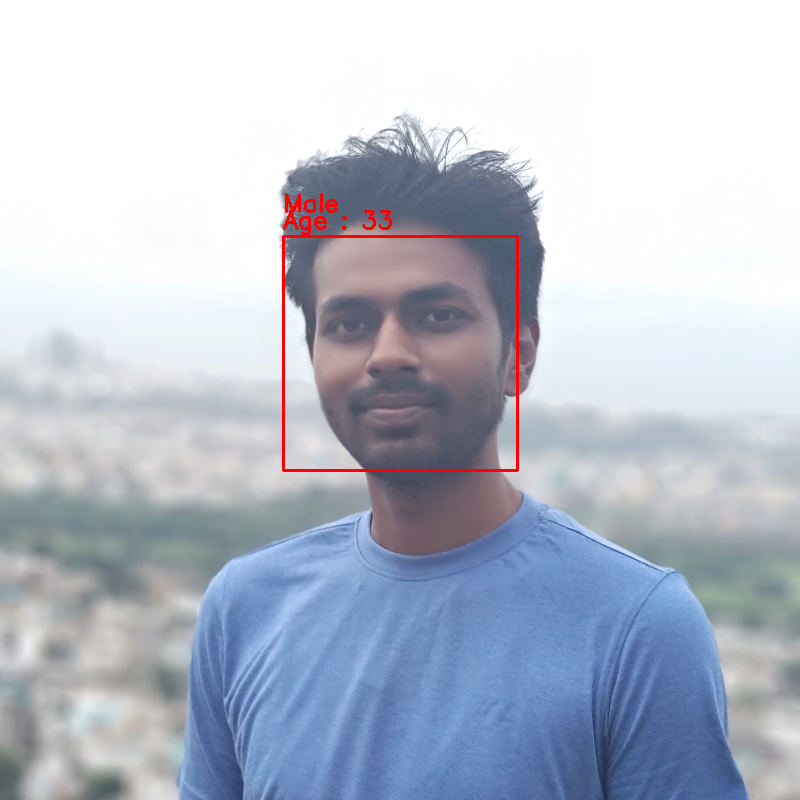

In [48]:
image = cv2.imread('IMG_20180812_171620.jpg')
pipeline(image)

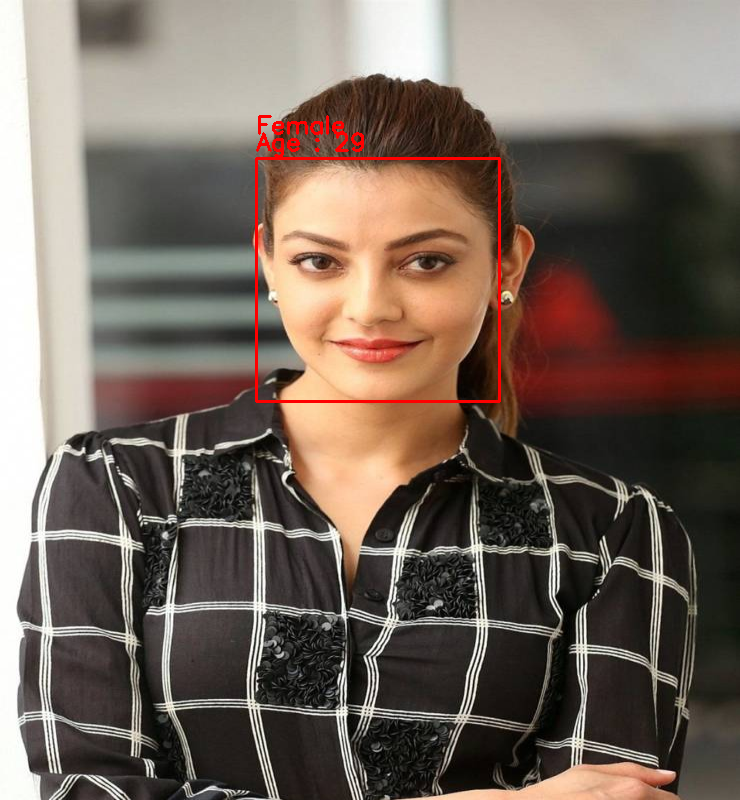

In [49]:
image = cv2.imread('kajal1.jpg')
pipeline(image)

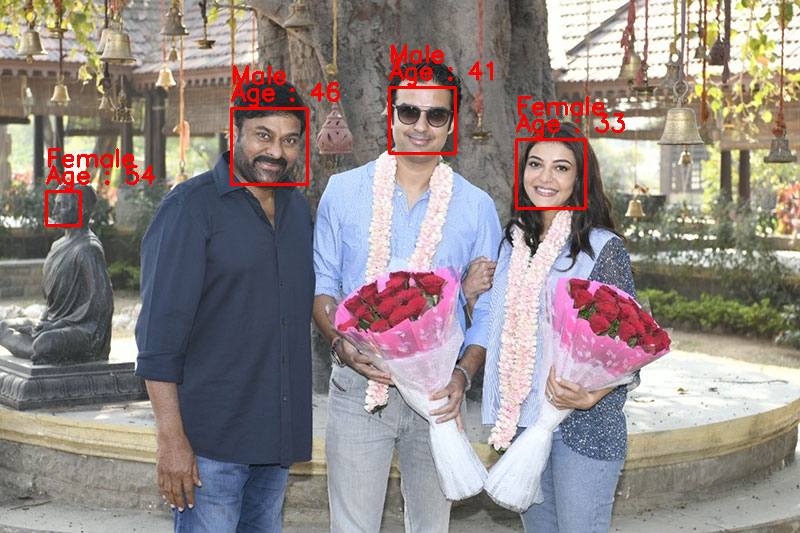

In [50]:
image = cv2.imread('kajal_chiru_acharya15122020_2c.jpg')
pipeline(image)

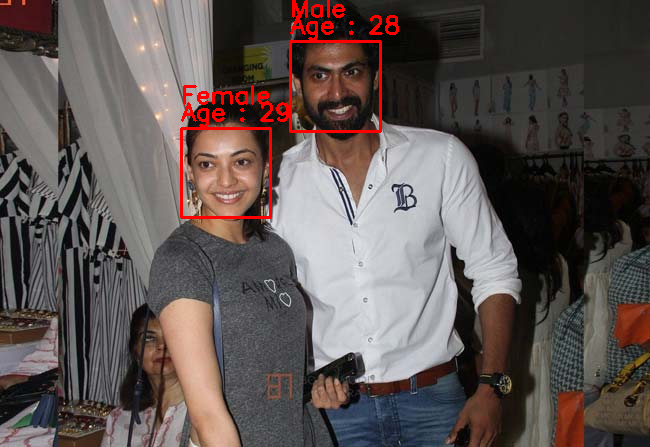

In [51]:
image = cv2.imread('rana.jpg')
pipeline(image)

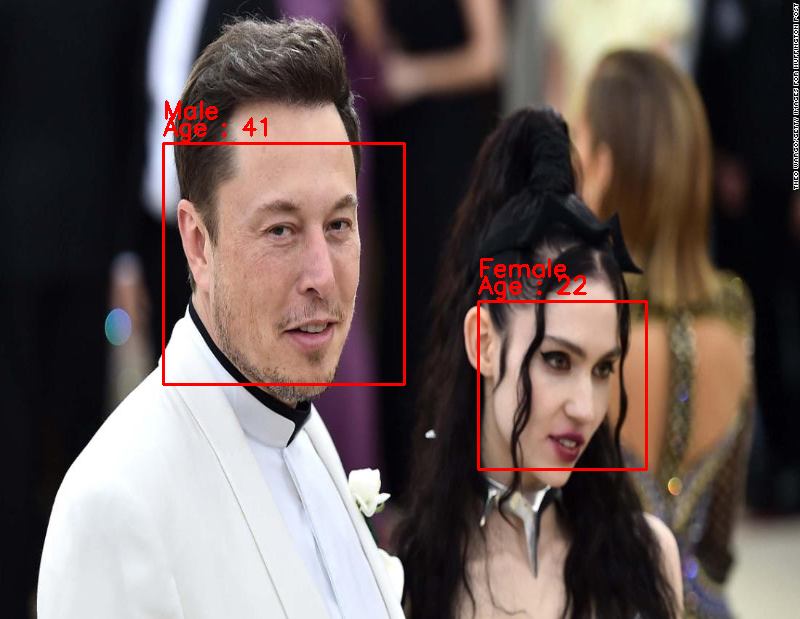

In [54]:
image = cv2.imread('elon45.jpg')
pipeline(image)

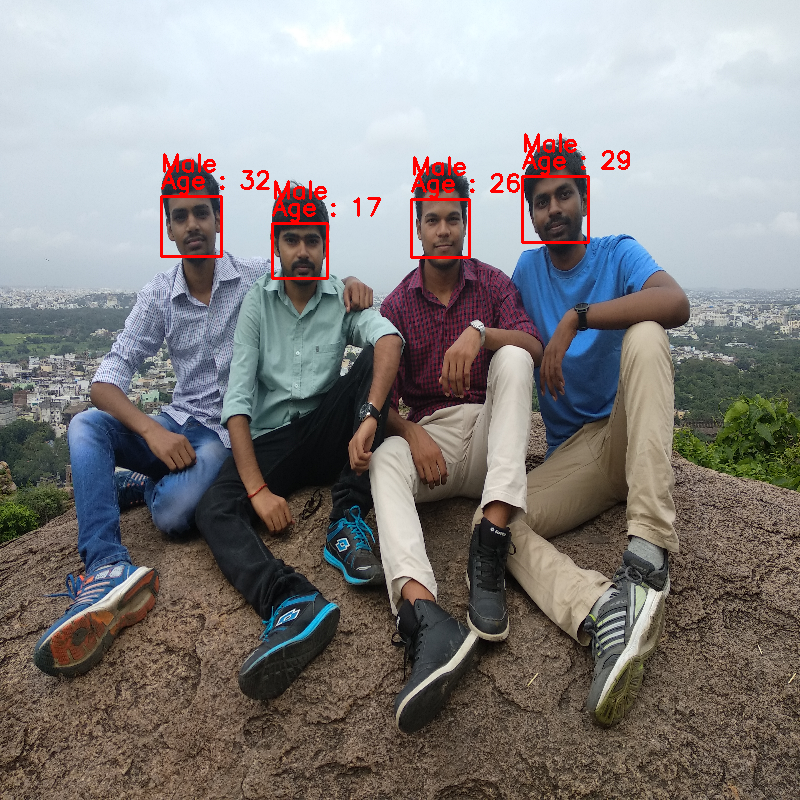

In [53]:
image = cv2.imread('IMG_20180812_172953.jpg')
pipeline(image)